## SMS Spam Classifier

In this project, I seek to create such a spam detection system, but on sms messages. I will use a few different models and compare their performance.

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam

![](spam.png)

### Project life cycle

#### 1. Data collection and manipulation
#### 2. Exploratory data analysis
$\;\;$ 2.1 Analyze the HAM / SPAM Rate<br>
$\;\;$ 2.2 Explore the relation of the messages with target<br>
$\;\;$ 2.3 WordClouds for HAM / SPAM<br>
#### 3. Preprocessing
$\;\;$ 3.1 Divide data
#### 4. Development, evaluation and optimization of models
$\;\;$ 4.1 Naive_bayes (GaussianNB)<br>
$\;\;$ 4.2 AdaBoostClassifier<br>
$\;\;$ 4.3 GradientBoostingClassifier<br>
$\;\;$ 4.4 RandomForestClassifier<br>
$\;\;$ 4.5 Xgboost<br>
$\;\;$ 4.6 Hyperparameter tuning<br>
$\;\;$ 4.7 best Models after Hyperparameter tuning<br>
$\;\;$ 4.8 Set model based on the vote<br>
#### Conclusion

## 1. Data collection and manipulation

In [100]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from PIL import Image
from scipy.stats import randint
import requests
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [8]:
# Load data
data = pd.read_csv("spam.csv",encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
data.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [11]:
# Sum of missing values for all features
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [12]:
# Percent of missing values
feature_with_nan = [feature for feature in data.columns if data[feature].isnull().sum()!=0]

print("Percent of features with Nan:","\n")
for feature in feature_with_nan:
    print(feature, ":", np.round(data[feature].isnull().sum()/len(data), 4)*100, "%")

Percent of features with Nan: 

Unnamed: 2 : 99.1 %
Unnamed: 3 : 99.78 %
Unnamed: 4 : 99.89 %


We note that there are three features with more than 99% of missing values, in this case, we propose to drop these features, because we can't replace it.

In [13]:
# Drop unnecessary columns
data = data.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [14]:
# Rename our 2 columns to make them more readable and meaningfull
data.rename(columns={"v1" : 'target', "v2" : 'message'}, inplace=True)
data.columns

Index(['target', 'message'], dtype='object')

## 2. Exploratory data analysis (EDA)

### 2.1 Analyze the HAM / SPAM Rate

ham     4825
spam     747
Name: target, dtype: int64
Percentage of ham : 86.59 %
Percentage of spam : 13.41 %


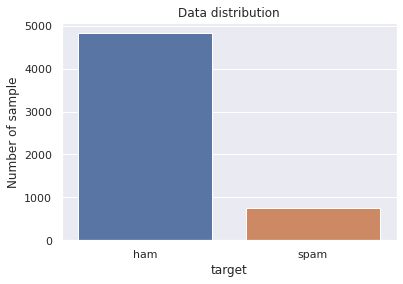

In [15]:
# Percentage by category for the target variable.
print(data["target"].value_counts())
pourcentage_target = data['target'].value_counts(normalize = True) * 100
print("Percentage of ham :",round(pourcentage_target[0],2), "%")
print("Percentage of spam :",round(pourcentage_target[1],2), "%")

# Plot the distribution of the data
sns.set()
sns.countplot(data.target).set_title('Data distribution')
ax = plt.gca()
sns.set(font_scale=1.5)
ax.set_xlabel("target") 
ax.set_ylabel("Number of sample")
plt.show()

From this graph, we can see that there are more sample with ham label ($ 86.59 \% $) compared to spam label ($13.41  \% $). Based on these results, we can conclude that the database is unbalanced.

### 2.2 Explore the relation of the messages with target

In [16]:
# calculate the length of messages 
data["length"] = data["message"].str.len()

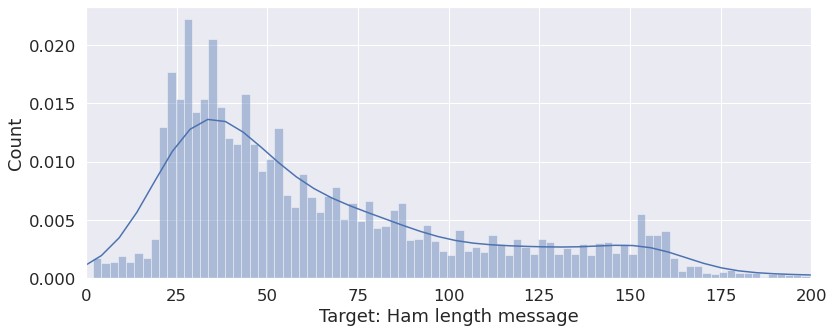

In [17]:
# plot the length of ham messages 
plt.figure(figsize=(13,5))
ax = plt.gca()
plt.xlim(0,200)
sns.distplot(data.loc[data["target"] == "ham"]["length"], kde_kws={"label": "Spam"},bins = 400)
ax.set_ylabel("Count")
ax.set_xlabel("Target: Ham length message")
plt.show()

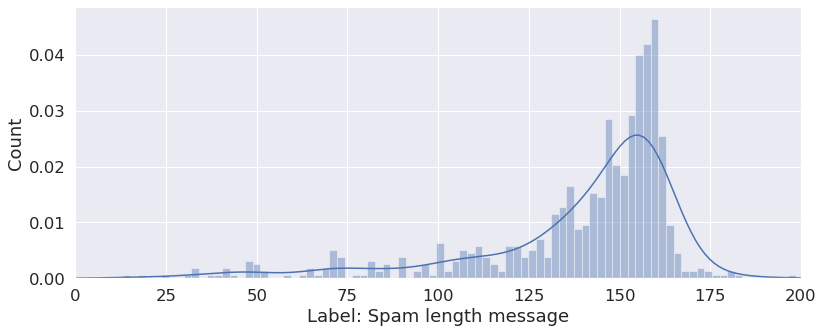

In [18]:
# plot the length of spam messages 
plt.figure(figsize=(13,5))
ax = plt.gca()
plt.xlim(0,200)
sns.distplot(data.loc[data["target"] == "spam"]["length"], bins = 100)
ax.set_ylabel("Count")
ax.set_xlabel("Label: Spam length message")
plt.show()

We conclude that the Spam messages tend to have more lengthy messages!

### 2.3 WordClouds for HAM / SPAM 

If we were to analyze the Spam / Ham messages and extract the important words based on its frequency, we use Word Clouds technique.

#### A) Tokenization Ham / Spam 

In [19]:
# Taking the spam stemmed words to put them in a word cloud
spam_words = ""
for val in data.loc[data["target"] == "spam"]["message"]: 
    val = str(val)
    tokens = val.split()
    spam_words += " ".join(tokens)+" "

In [20]:
# Taking the ham stemmed words to put them in a word cloud
ham_words = ""
for val in data.loc[data["target"] == "ham"]["message"]: 
    val = str(val)
    tokens = val.split()
    ham_words += " ".join(tokens)+" "

The above code helps us to tokenize a sentence and convert each word or token into a lower case. 

#### B) Generation of Word cloud

In [21]:
# Downloading the pic to use and defining our spam_word cloud
pic = np.array(Image.open(requests.get('http://www.clker.com/cliparts/O/i/x/Y/q/P/yellow-house-hi.png'
                                       ,stream=True).raw))
# Defining our spam_word cloud
spam_wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white', mask = pic, 
                      min_font_size = 10).generate(spam_words)

# Defining our ham_word cloud
ham_wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white', mask = pic, 
                      min_font_size = 10).generate(ham_words)

#### Generation of Word cloud for SPAM messages

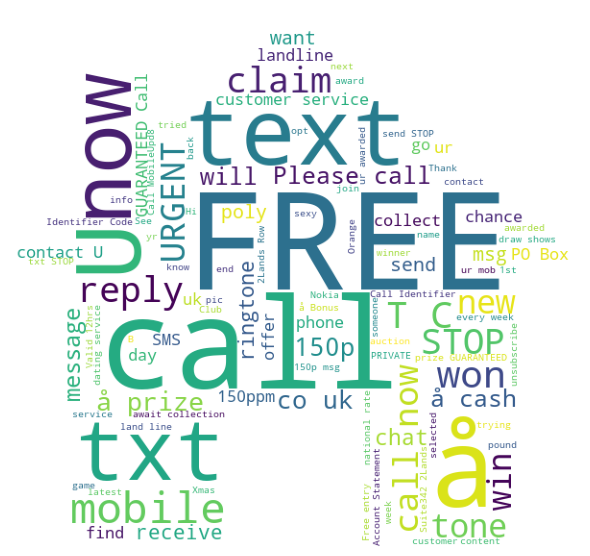

In [22]:
# Displaying the word cloud of most frequent stemmed spam sms messages words.
plt.figure(figsize = (8, 8), facecolor = 'white', edgecolor='blue') 
plt.imshow(spam_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

This WordCloud was obtained with the extracted the most relevant terms that describe the Spam message: FREE,  call,  text, claim , ..., etc.

#### Generation of Word cloud for HAM messages

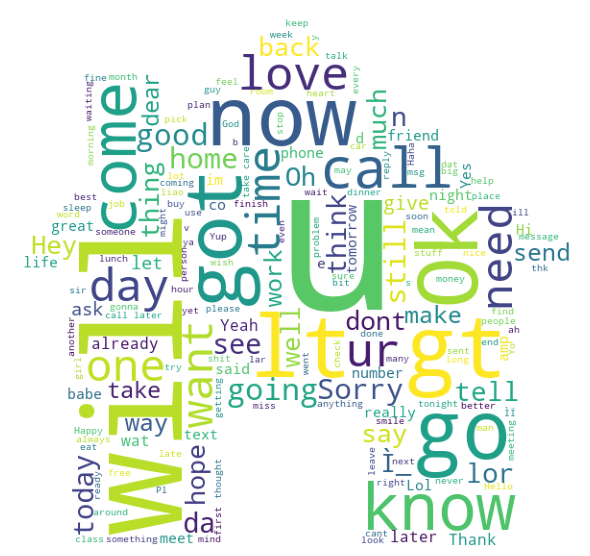

In [23]:
# Displaying the word cloud of most frequent stemmed ham sms messages words.
plt.figure(figsize = (8, 8), facecolor = 'white', edgecolor='blue') 
plt.imshow(ham_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

This WordCloud was obtained with theextracted the most relevant terms that describe the Ham message. got,  will,  call, know, ..., etc.

## 3) Preprocessing

Text preprocessing is an approach for cleaning and preparing text data for use in a specific context. Developers use it in almost all natural language processing (NLP) pipelines, including voice recognition software, search engine lookup, and machine learning model training. It is an essential step because text data can vary. From its format (website, text message, voice recognition) to the people who create the text (language, dialect), there are plenty of things that can introduce noise into your data.

We will use few common approaches for cleaning and processing text data. They include:

$\;\;\;\;\;$ * Using Regex & NLTK libraries<br>
$\;\;\;\;\;$ * Removing unnecessary characters and formatting<br>
$\;\;\;\;\;$ * Tokenization – break multi-word strings into smaller components<br>
$\;\;\;\;\;$ * Normalization – a catch-all term for processing data; this includes stemming and lemmatization<br>

In [24]:
#Create copy dataset to manipulate
manip_dataset = data.copy()
manip_dataset.head()

,target,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [25]:
# cleaned texts
import re
import nltk
nltk.download('stopwords') #download non relevant words
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer # Stemming is taking the root of every word (containing what it means)
sms = [] # will contain all the different sms cleaned
for i in range(0, len(data)):
    string = re.sub("[^a-zA-Z]", " ", manip_dataset["message"][i]) # replaces anything NOT in a-z or A-Z by a space, in the variable 
    string = string.lower()
    string = string.split()
    stemmer = SnowballStemmer("english")
    all_stopwords = stopwords.words("english")
    #if the word is not in the stopwords vocabulary then go ahead with the word iter and stem it
    string = [stemmer.stem(word) for word in string if not word in set(all_stopwords)]
    string = ' '.join(string) # joins the words again with a space in between them
    sms.append(string) # add the cleaned message to our sms list


[nltk_data] Downloading package stopwords to /home/bilal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# See the first 5 stemmed messages
sms[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkts st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though']

In [27]:
# Iterate through the list and replace the old texts with the new cleaned texts
for i in range(0,len(sms)):
    manip_dataset["message"][i] = sms[i] 
    
manip_dataset.head()

,target,message,length
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri wkli comp win fa cup final tkts st ...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah think goe usf live around though,61


In [28]:
# Creating new feature for the length of the "cleaned" messages
manip_dataset["after_length"] = manip_dataset["message"].str.len()
manip_dataset.head()

,target,message,length,after_length
0,ham,go jurong point crazi avail bugi n great world...,111,76
1,ham,ok lar joke wif u oni,29,21
2,spam,free entri wkli comp win fa cup final tkts st ...,155,100
3,ham,u dun say earli hor u c alreadi say,49,35
4,ham,nah think goe usf live around though,61,36


<AxesSubplot:xlabel='length', ylabel='Density'>

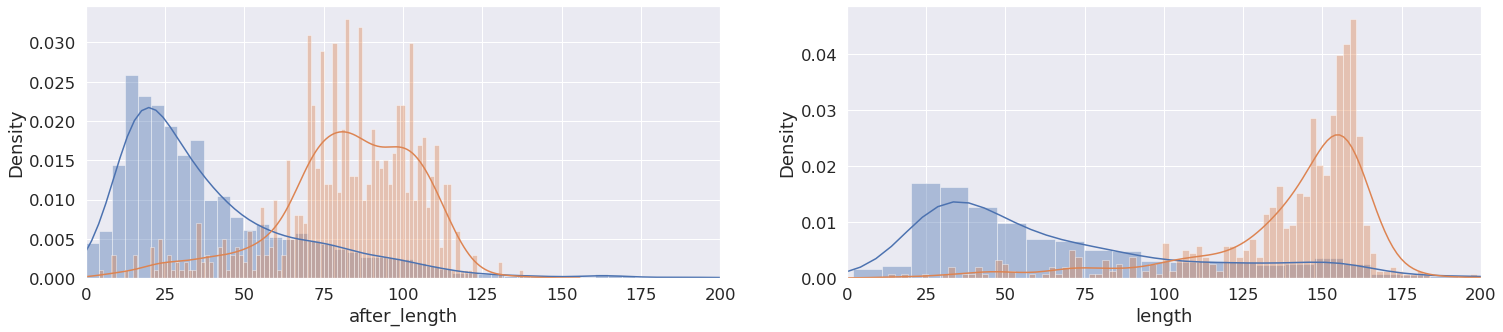

In [29]:
# Comparison between the distribution of the length of messages (Ham / spam) after and before cleaning
fig, ax =plt.subplots(1,2,figsize=(25,5))
ax[0].set_xlim([0, 200])
ax[1].set_xlim([0, 200])


sns.distplot(manip_dataset.loc[manip_dataset["target"] == "ham"]["after_length"], 
                     kde_kws={"label": "Ham"}, bins = 100, ax = ax[0])
sns.distplot(manip_dataset.loc[manip_dataset["target"] == "spam"]["after_length"], 
                     kde_kws={"label": "Spam"}, bins = 100, ax = ax[0])

sns.distplot(manip_dataset.loc[manip_dataset["target"] == "ham"]["length"], 
                     kde_kws={"label": "Ham"}, bins = 100, ax = ax[1])
sns.distplot(manip_dataset.loc[manip_dataset["target"] == "spam"]["length"], 
                     kde_kws={"label": "Spam"}, bins = 100, ax = ax[1])

Length distributions more discrete in initial length, so we will not use the after_length feature

In [73]:
# drop the after_length feature and divide data into predictor messages and target 
X = manip_dataset.drop(columns = ["target"])
#y = manip_dataset["target"]
# use get_dummies and replaced the target values: spam by 1 and ham by 0.
manip_dataset_ohe = manip_dataset.copy()
manip_dataset_ohe["target"]= pd.get_dummies(manip_dataset['target'], drop_first=True)
y = manip_dataset_ohe["target"]

In the Preprocessing step, we use $CountVectorizer$ tokenizes (tokenization means breaking down a sentence or paragraph or any text into words) to remove the punctuation marks, converting all the words to lowercase, etc.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 4001) # the one at the end is because i'll use the last one for the length feature

In [58]:
# Create our vectors for our bag-of-words model
X_message = cv.fit_transform(sms).toarray()

In [59]:
# Assign the last value of each vector to the length feature
for i in range(0,len(X_message)):
    X_message[i][-1] = X["length"][i]

In [60]:
# Display first five vectors
X_message[:5]

array([[  0,   0,   0, ...,   0,   0, 111],
       [  0,   0,   0, ...,   0,   0,  29],
       [  0,   0,   0, ...,   0,   0, 155],
       [  0,   0,   0, ...,   0,   0,  49],
       [  0,   0,   0, ...,   0,   0,  61]])

### 3.1 Divide data

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_message, y, test_size=0.20, random_state=42)

## 4. Development, evaluation and optimization of models
Because, we are dealing with a critical problem, for this, we need a model with high performance. Here I am going to try 5 machine learning algorithms, with the aim to find the machine learning algorithm that works best. In addition, we will perform a precision comparison between them for the final choice.
Since the project is a classification problem, the algorithms we will choose are the following:
* Naive_bayes (GaussianNB)
* AdaBoostClassifier
* GradientBoostingClassifier
* RandomForestClassifier
* Xgboost

In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [64]:
# Function to print metrics
def print_metrics(y_test,y_pred):
    print("The confusion matrix is : \n", confusion_matrix(y_test, y_pred), "\n")
    print("The accuracy score is : \n",accuracy_score(y_test, y_pred), "\n")
    print("The precision is : \n",precision_score(y_test,y_pred), "\n")
    print("The recall is : \n",recall_score(y_test,y_pred), "\n")
    print("The f1 score is : \n",f1_score(y_test,y_pred), "\n")

In [65]:
# Create function running models and printing scores
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_metrics(y_test,y_pred)
    return model

#### 4.1 Naive_bayes (GaussianNB)

In [83]:
from sklearn.naive_bayes import GaussianNB
NV_model = run_model(GaussianNB(),X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[827 138]
 [ 16 134]] 

The accuracy score is : 
 0.8618834080717489 

The precision is : 
 0.49264705882352944 

The recall is : 
 0.8933333333333333 

The f1 score is : 
 0.6350710900473934 



#### 4.2 AdaBoostClassifier

In [84]:
from sklearn.ensemble import AdaBoostClassifier
AdaBoost_model = run_model(AdaBoostClassifier(random_state = 42),X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[958   7]
 [ 31 119]] 

The accuracy score is : 
 0.9659192825112107 

The precision is : 
 0.9444444444444444 

The recall is : 
 0.7933333333333333 

The f1 score is : 
 0.8623188405797102 



#### 4.3 GradientBoostingClassifier

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoost_model = run_model(GradientBoostingClassifier(random_state = 42),X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[960   5]
 [ 32 118]] 

The accuracy score is : 
 0.9668161434977578 

The precision is : 
 0.959349593495935 

The recall is : 
 0.7866666666666666 

The f1 score is : 
 0.8644688644688644 



#### 4.4 RandomForestClassifier

In [86]:
from sklearn.ensemble import RandomForestClassifier
RF_model = run_model(RandomForestClassifier(random_state = 42),X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[965   0]
 [ 23 127]] 

The accuracy score is : 
 0.979372197309417 

The precision is : 
 1.0 

The recall is : 
 0.8466666666666667 

The f1 score is : 
 0.9169675090252708 



#### 4.5 Xgboost

In [72]:
import xgboost
xgboost_model = run_model(xgboost.XGBClassifier(random_state = 42),X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[962   3]
 [ 19 131]] 

The accuracy score is : 
 0.9802690582959641 

The precision is : 
 0.9776119402985075 

The recall is : 
 0.8733333333333333 

The f1 score is : 
 0.9225352112676056 



As we can see, in the output above, GradietBoosting, Xgboost, and RandomForestClassifier are performing well.

As we can see by the above metrics our best model, RandomForest Classifier, detected spam sms messages with accuracy 97,9%.
Also we can see that all the spams we detected, were indeed ACTUALLY spams (precision = 100%) but we missed approximately 15% (recall = 84.66%) of all the spam messages.

### 4.6  Hyperparameter tuning

Here we will see how we can get optimum values for the parameters. The *RandomizedSearchCV* hyperparameter tuning method will be used in this process.

In [109]:
# Create function running randomized search on model given in the parameters
def run_grid_model(model, grid, X_train, y_train, X_test, y_test):
    model_random = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    model_random.fit(X_train, y_train)
    print(f"Best params of the randomized CV-2 model is : {model_random.best_params_} \n-----------------------------------")
    y_pred = model_random.predict(X_test)
    print_metrics(y_test,y_pred)

In [ ]:
# Create the random grid for RF
random_grid = {'n_estimators': [int(x) for x in np.linspace(200, 2000, num = 7)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 100, num= 7)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [75]:
# Perform RandomizedSearch on our random forest classifier
run_grid_model(RandomForestClassifier(random_state = 42),random_grid, X_train, y_train, X_test, y_test)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 38.2min finished


Best params of the randomized CV-2 model is : {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False} 
-----------------------------------
The confusion matrix is : 
 [[965   0]
 [ 20 130]] 

The accuracy score is : 
 0.9820627802690582 

The precision is : 
 1.0 

The recall is : 
 0.8666666666666667 

The f1 score is : 
 0.9285714285714286 



In [101]:
# Create the random grid for GBoost
random_grid_GBoost = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': range(1,10)}

In [102]:
# Perform RandomizedSearch on our GradientBoostingClassifier classifier
run_grid_model(GradientBoostingClassifier(random_state = 42),random_grid_GBoost, X_train, y_train, X_test, y_test)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 108.1min finished


Best params of the randomized CV-2 model is : {'loss': 'exponential', 'max_depth': 6, 'n_estimators': 352} 
-----------------------------------
The confusion matrix is : 
 [[964   1]
 [ 23 127]] 

The accuracy score is : 
 0.97847533632287 

The precision is : 
 0.9921875 

The recall is : 
 0.8466666666666667 

The f1 score is : 
 0.9136690647482014 



In [ ]:
# Create the random grid for XGBoost
random_grid_XGBoost = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
                        "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                        "min_child_weight" : [ 1, 3, 5, 7 ],
                        "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
# Perform RandomizedSearch on our xgboost.XGBClassifier classifier
run_grid_model(xgboost.XGBClassifier(random_state = 42),random_grid_XGBoost, X_train, y_train, X_test, y_test)

### 4.7 best Models after Hyperparameter tuning

In [107]:
## RandomForestClassifier
model = RandomForestClassifier(n_estimators= 1400, min_samples_split= 5, min_samples_leaf= 1, max_features= 'auto', max_depth= 100, bootstrap= False, random_state = 42)
best_RF_model = run_model(model, X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[965   0]
 [ 20 130]] 

The accuracy score is : 
 0.9820627802690582 

The precision is : 
 1.0 

The recall is : 
 0.8666666666666667 

The f1 score is : 
 0.9285714285714286 



In [104]:
## GradientBoostingClassifier
model = GradientBoostingClassifier(loss = 'exponential', max_depth = 6, n_estimators = 352, random_state = 42)
best_GradientBoost_model = run_model(model, X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[964   1]
 [ 23 127]] 

The accuracy score is : 
 0.97847533632287 

The precision is : 
 0.9921875 

The recall is : 
 0.8466666666666667 

The f1 score is : 
 0.9136690647482014 



### 4.8 Set model based on the vote

In [108]:
# Import the VotingClassifier template
from sklearn.ensemble import VotingClassifier

# Model initialization
votingMod = VotingClassifier(estimators=[('gb', best_GradientBoost_model),
                                         ('rf', best_RF_model),
                                         ('xgb', xgboost_model)],
                                         voting = 'soft', weights=[1.5,2,1])
# Fitting 
VM_model = run_model(votingMod,X_train, y_train, X_test, y_test)

The confusion matrix is : 
 [[965   0]
 [ 24 126]] 

The accuracy score is : 
 0.97847533632287 

The precision is : 
 1.0 

The recall is : 
 0.84 

The f1 score is : 
 0.9130434782608696 



# Conclusion

After using multiple models I ended up with three models GradientBoosting, xgboost, and RandomForest that performed better than other ML models. I decided to go further with the three and set up a voting system for the three which will allow me to choose the best model.